In [1]:
#####
#####  RUN NOTES
#####

# Eating disorders Montecatini, HDDM analysis
# Controls, at-risk participants, and patients split by diagnostic category. 
# Written by Corrado Caudek

#####
#####  PURPOSE
#####

# The present script is used for the HDDMrl analysis of performance in the PRL 
# task with food and neutral images.
# With this script, the HDDMrl parameters are estimated separately for each of 
# 6 groups: 
# - AN     anorexia, 
# - AN-R   anorexia in remission, 
# - BN     bulimia, 
# - BN-R   bulimia in remission, 
# - RI     university students at risk according to the EAT-26,
# - HC     university students not at risk according to the EAT-26.

import datetime 
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-06-11 13:42:34


In [2]:
# MODULE IMPORTS ----

# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.utils import concat_models
import pathlib

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# HDDM
import hddm
print(hddm.__version__)

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.9.7


In [3]:
pwd

'/Users/corrado/Dropbox/in_progress/01_TODO_ED_MONTECATINI/scripts/python/PRL/01_analysis'

In [4]:
#####
#####  READ DATA
#####

data = hddm.load_csv('/Users/corrado/_repositories/eating_disorders_montecatini/data/processed/prl/input_for_hddmrl/hddm_input_20220603v2.csv') 

There are 311 participants


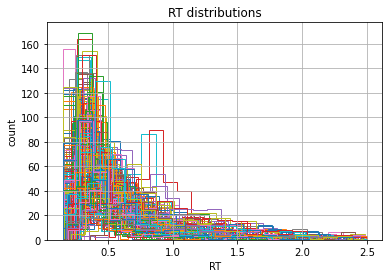

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
plt.savefig('plot_hist_rt_patients.pdf')

print('There are %d participants' %data['subj_idx'].nunique())

In [6]:
data.head()

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
0,1,0,food,0.979,1,0,0,AN,ca_po_2002_05_25_700_f,0.5
1,1,0,neutral,1.553,1,1,0,AN,ca_po_2002_05_25_700_f,0.5
2,1,1,food,1.939,2,0,0,AN,ca_po_2002_05_25_700_f,0.5
3,1,1,neutral,0.350,2,1,1,AN,ca_po_2002_05_25_700_f,0.5
4,1,0,food,0.768,3,0,0,AN,ca_po_2002_05_25_700_f,0.5


In [7]:
data.groupby(['diag_cat', 'stim']).agg({'feedback': 'mean'})

feedback
diag_cat stim             
AN       food     0.531250
         neutral  0.550714
AN_R     food     0.521528
         neutral  0.535625
BN       food     0.537500
         neutral  0.541250
BN_R     food     0.546250
         neutral  0.523750
HC       food     0.543810
         neutral  0.544511
RI       food     0.543269
         neutral  0.568155

In [8]:
data.groupby(['diag_cat', 'stim']).agg({'rt': 'mean'})

rt
diag_cat stim             
AN       food     0.676011
         neutral  0.592044
AN_R     food     0.708483
         neutral  0.569473
BN       food     0.680351
         neutral  0.531536
BN_R     food     0.658710
         neutral  0.592061
HC       food     0.598443
         neutral  0.557056
RI       food     0.602302
         neutral  0.522246

In [9]:
df = data[data.diag_cat == 'AN']
df.describe()

,subj_idx,response,rt,trial,split_by,feedback,q_init
count,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000,11360.0
mean,38.633803,0.465317,0.634619,80.500000,0.492958,0.540845,0.5
std,46.814915,0.498818,0.405018,46.189152,0.499972,0.498351,0.0
min,1.000000,0.000000,0.150000,1.000000,0.000000,0.000000,0.5
25%,14.000000,0.000000,0.351000,40.750000,0.000000,0.000000,0.5
50%,32.000000,0.000000,0.512000,80.500000,0.000000,1.000000,0.5
75%,48.000000,1.000000,0.796000,120.250000,1.000000,1.000000,0.5
max,295.000000,1.000000,2.488000,160.000000,1.000000,1.000000,0.5


In [10]:
df1 = data[data.diag_cat == 'HC']
df1.describe()

,subj_idx,response,rt,trial,split_by,feedback,q_init
count,64640.000000,64640.000000,64640.000000,64640.000000,64640.000000,64640.000000,64640.0
mean,186.215347,0.473484,0.578262,80.500000,0.487624,0.544152,0.5
std,69.949749,0.499300,0.383188,46.187477,0.499851,0.498051,0.0
min,63.000000,0.000000,0.150000,1.000000,0.000000,0.000000,0.5
25%,127.500000,0.000000,0.331750,40.750000,0.000000,0.000000,0.5
50%,188.000000,0.000000,0.449000,80.500000,0.000000,1.000000,0.5
75%,247.000000,1.000000,0.685000,120.250000,1.000000,1.000000,0.5
max,311.000000,1.000000,2.499000,160.000000,1.000000,1.000000,0.5


In [11]:
#####
#####  RUN MODEL mod1
#####

# a = decision threshold
# v = drift rate
# t = non-decision time 
# alpha = learning rate

mod1 = hddm.HDDMrl(
  data,
  bias = True,
  depends_on = {
      'a':['diag_cat', 'stim'],
      'v':['diag_cat', 'stim'],
      't':['diag_cat', 'stim'],
      'alpha':['diag_cat', 'stim'],
      'pos_alpha':['diag_cat', 'stim']
     },
  dual = True, # separate learning rates for pos/neg feedbacks
  p_outlier = 0.05
)

In [12]:
mod1.find_starting_values()

/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [13]:
mod1.sample(10000, burn=5000, dbname='traces.db', db='pickle')

 [-----------------100%-----------------] 10001 of 10000 complete in 25308.0 sec

In [17]:
alpha_an_f,  alpha_an_n, alpha_anr_f, alpha_anr_n, alpha_bn_f,  alpha_bn_n, alpha_bnr_f, alpha_bnr_n, alpha_hc_f,  alpha_hc_n, alpha_ri_f,  alpha_ri_n = mod1.nodes_db.node[[
    'alpha(AN.food)',   'alpha(AN.neutral)', 
    'alpha(AN_R.food)', 'alpha(AN_R.neutral)', 
    'alpha(BN.food)',   'alpha(BN.neutral)', 
    'alpha(BN_R.food)', 'alpha(BN_R.neutral)', 
    'alpha(HC.food)',   'alpha(HC.neutral)', 
    'alpha(RI.food)',   'alpha(RI.neutral)', 
    ]]

In [18]:
pos_alpha_an_f,  pos_alpha_an_n, pos_alpha_anr_f, pos_alpha_anr_n, pos_alpha_bn_f,  pos_alpha_bn_n, pos_alpha_bnr_f, pos_alpha_bnr_n, pos_alpha_hc_f,  pos_alpha_hc_n, pos_alpha_ri_f,  pos_alpha_ri_n = mod1.nodes_db.node[[
    'pos_alpha(AN.food)',   'pos_alpha(AN.neutral)', 
    'pos_alpha(AN_R.food)', 'pos_alpha(AN_R.neutral)', 
    'pos_alpha(BN.food)',   'pos_alpha(BN.neutral)', 
    'pos_alpha(BN_R.food)', 'pos_alpha(BN_R.neutral)', 
    'pos_alpha(HC.food)',   'pos_alpha(HC.neutral)', 
    'pos_alpha(RI.food)',   'pos_alpha(RI.neutral)', 
    ]]

In [23]:
mod1.plot_posterior_predictive()


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

# Alpha 

Text(0.5, 1.0, 'Posterior of negative alpha group means')

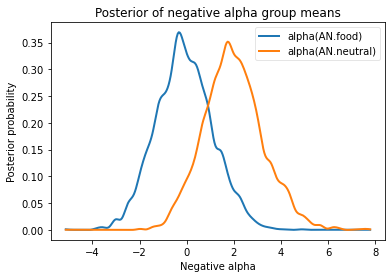

In [24]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_an_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')

Text(0.5, 1.0, 'Posterior of negative alpha group means')

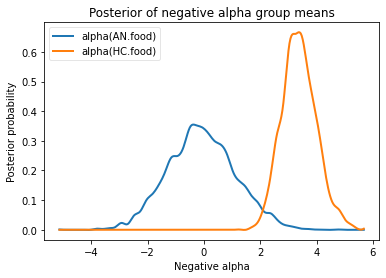

In [25]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_hc_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')

Text(0.5, 1.0, 'Posterior of negative alpha group means')

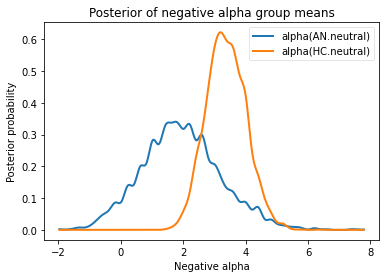

In [27]:
hddm.analyze.plot_posterior_nodes([alpha_an_n, alpha_hc_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')

Text(0.5, 1.0, 'Posterior of positive alpha group means')

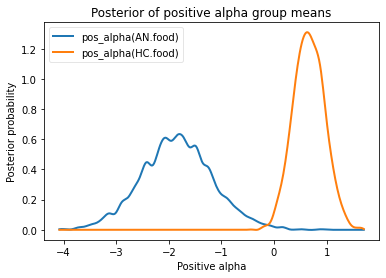

In [28]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_f, pos_alpha_hc_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')

Text(0.5, 1.0, 'Posterior of positive alpha group means')

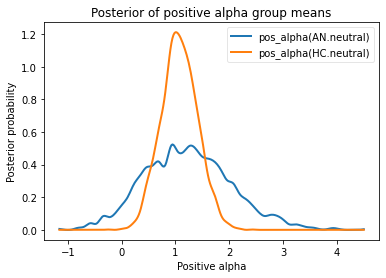

In [29]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_n, pos_alpha_hc_n])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')

In [30]:
print("P(neg-alpha AN food > neg-alpha HC food) = ", (alpha_an_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha AN neutral > neg-alpha HC neutral) = ", (alpha_an_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha AN food > pos-alpha HC food) = ", (pos_alpha_an_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha AN neutral > pos-alpha HC neutral) = ", (pos_alpha_an_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha AN food > neg-alpha HC food) =  0.0044
P(neg-alpha AN neutral > neg-alpha HC neutral) =  0.1506
P(pos-alpha AN food > pos-alpha HC food) =  0.0006
P(pos-alpha AN neutral > pos-alpha HC neutral) =  0.5666


In [31]:
print("P(neg-alpha AN-R food > neg-alpha HC food) = ", (alpha_anr_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha AN-R neutral > neg-alpha HC neutral) = ", (alpha_anr_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha AN-R food > pos-alpha HC food) = ", (pos_alpha_anr_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha AN-R neutral > pos-alpha HC neutral) = ", (pos_alpha_anr_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha AN-R food > neg-alpha HC food) =  0.3806
P(neg-alpha AN-R neutral > neg-alpha HC neutral) =  0.3356
P(pos-alpha AN-R food > pos-alpha HC food) =  0.6082
P(pos-alpha AN-R neutral > pos-alpha HC neutral) =  0.341


In [32]:
print("P(neg-alpha BN food > neg-alpha HC food) = ", (alpha_bn_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha BN neutral > neg-alpha HC neutral) = ", (alpha_bn_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha BN food > pos-alpha HC food) = ", (pos_alpha_bn_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN neutral > pos-alpha HC neutral) = ", (pos_alpha_bn_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN food > neg-alpha HC food) =  0.092
P(neg-alpha BN neutral > neg-alpha HC neutral) =  0.1928
P(pos-alpha BN food > pos-alpha HC food) =  0.4228
P(pos-alpha BN neutral > pos-alpha HC neutral) =  0.453


In [33]:
print("P(neg-alpha BN-R food > neg-alpha HC food) = ", (alpha_bnr_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha BN-R neutral > neg-alpha HC neutral) = ", (alpha_bnr_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha BN-R food > pos-alpha HC food) = ", (pos_alpha_bnr_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN-R neutral > pos-alpha HC neutral) = ", (pos_alpha_bnr_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN-R food > neg-alpha HC food) =  0.3944
P(neg-alpha BN-R neutral > neg-alpha HC neutral) =  0.3504
P(pos-alpha BN-R food > pos-alpha HC food) =  0.6962
P(pos-alpha BN-R neutral > pos-alpha HC neutral) =  0.4394


In [34]:
print("P(neg-alpha RI food > neg-alpha HC food) = ", (alpha_ri_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha RI neutral > neg-alpha HC neutral) = ", (alpha_ri_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha RI food > pos-alpha HC food) = ", (pos_alpha_ri_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha RI neutral > pos-alpha HC neutral) = ", (pos_alpha_ri_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha RI food > neg-alpha HC food) =  0.3738
P(neg-alpha RI neutral > neg-alpha HC neutral) =  0.1534
P(pos-alpha RI food > pos-alpha HC food) =  0.512
P(pos-alpha RI neutral > pos-alpha HC neutral) =  0.675


# Drift rate

In [35]:
v_an_f,  v_an_n, v_anr_f, v_anr_n, v_bn_f,  v_bn_n, v_bnr_f, v_bnr_n, v_hc_f,  v_hc_n, v_ri_f,  v_ri_n = mod1.nodes_db.node[[
    'v(AN.food)',   'v(AN.neutral)', 
    'v(AN_R.food)', 'v(AN_R.neutral)', 
    'v(BN.food)',   'v(BN.neutral)', 
    'v(BN_R.food)', 'v(BN_R.neutral)', 
    'v(HC.food)',   'v(HC.neutral)', 
    'v(RI.food)',   'v(RI.neutral)', 
    ]]

In [36]:
print("P(v AN food > v HC food) = ", (v_an_f.trace() > v_hc_f.trace()).mean())
print("P(v AN neutral > v HC neutral) = ", (v_an_n.trace() > v_hc_n.trace()).mean())
print("P(v AN-R food > v HC food) = ", (v_anr_f.trace() > v_hc_f.trace()).mean())
print("P(v AN-R neutral > v HC neutral) = ", (v_anr_n.trace() > v_hc_n.trace()).mean())

P(v AN food > v HC food) =  0.587
P(v AN neutral > v HC neutral) =  0.035
P(v AN-R food > v HC food) =  0.2684
P(v AN-R neutral > v HC neutral) =  0.5786


In [37]:
print("P(v BN food > v HC food) = ", (v_bn_f.trace() > v_hc_f.trace()).mean())
print("P(v BN neutral > v HC neutral) = ", (v_bn_n.trace() > v_hc_n.trace()).mean())
print("P(v BN-R food > v HC food) = ", (v_bnr_f.trace() > v_hc_f.trace()).mean())
print("P(v BN-R neutral > v HC neutral) = ", (v_bnr_n.trace() > v_hc_n.trace()).mean())

P(v BN food > v HC food) =  0.257
P(v BN neutral > v HC neutral) =  0.8678
P(v BN-R food > v HC food) =  0.3064
P(v BN-R neutral > v HC neutral) =  0.4306


In [38]:
print("P(v RI food > v HC food) = ", (v_ri_f.trace() > v_hc_f.trace()).mean())
print("P(v RI neutral > v HC neutral) = ", (v_ri_n.trace() > v_hc_n.trace()).mean())

P(v RI food > v HC food) =  0.2242
P(v RI neutral > v HC neutral) =  0.7484


# Decision threshold

In [40]:
a_an_f,  a_an_n, a_anr_f, a_anr_n, a_bn_f,  a_bn_n, a_bnr_f, a_bnr_n, a_hc_f,  a_hc_n, a_ri_f,  a_ri_n = mod1.nodes_db.node[[
    'a(AN.food)',   'a(AN.neutral)', 
    'a(AN_R.food)', 'a(AN_R.neutral)', 
    'a(BN.food)',   'a(BN.neutral)', 
    'a(BN_R.food)', 'a(BN_R.neutral)', 
    'a(HC.food)',   'a(HC.neutral)', 
    'a(RI.food)',   'a(RI.neutral)', 
    ]]

In [41]:
print("P(a AN food < a HC food) = ", (a_an_f.trace() < a_hc_f.trace()).mean())
print("P(a AN neutral < a HC neutral) = ", (a_an_n.trace() < a_hc_n.trace()).mean())
print("P(a AN-R food < a HC food) = ", (a_anr_f.trace() < a_hc_f.trace()).mean())
print("P(a AN-R neutral < a HC neutral) = ", (a_anr_n.trace() < a_hc_n.trace()).mean())

P(a AN food < a HC food) =  0.0352
P(a AN neutral < a HC neutral) =  0.3926
P(a AN-R food < a HC food) =  0.5182
P(a AN-R neutral < a HC neutral) =  0.2428


In [42]:
print("P(a BN food < a HC food) = ", (a_bn_f.trace() < a_hc_f.trace()).mean())
print("P(a BN neutral < a HC neutral) = ", (a_bn_n.trace() < a_hc_n.trace()).mean())
print("P(a BN-R food < a HC food) = ", (a_bnr_f.trace() < a_hc_f.trace()).mean())
print("P(a BN-R neutral < a HC neutral) = ", (a_bnr_n.trace() < a_hc_n.trace()).mean())

P(a BN food < a HC food) =  0.0844
P(a BN neutral < a HC neutral) =  0.6522
P(a BN-R food < a HC food) =  0.4238
P(a BN-R neutral < a HC neutral) =  0.399


In [43]:
print("P(a RI food < a HC food) = ", (a_ri_f.trace() < a_hc_f.trace()).mean())
print("P(a RI neutral < a HC neutral) = ", (a_ri_n.trace() < a_hc_n.trace()).mean())

P(a RI food < a HC food) =  0.6668
P(a RI neutral < a HC neutral) =  0.6984


# Non decision time

In [44]:
t_an_f,  t_an_n, t_anr_f, t_anr_n, t_bn_f,  t_bn_n, t_bnr_f, t_bnr_n, t_hc_f,  t_hc_n, t_ri_f,  t_ri_n = mod1.nodes_db.node[[
    't(AN.food)',   't(AN.neutral)', 
    't(AN_R.food)', 't(AN_R.neutral)', 
    't(BN.food)',   't(BN.neutral)', 
    't(BN_R.food)', 't(BN_R.neutral)', 
    't(HC.food)',   't(HC.neutral)', 
    't(RI.food)',   't(RI.neutral)', 
    ]]

In [46]:
print("P(t AN food < t HC food) = ", (t_an_f.trace() < t_hc_f.trace()).mean())
print("P(t AN neutral < t HC neutral) = ", (t_an_n.trace() < t_hc_n.trace()).mean())
print("P(t AN-R food < t HC food) = ", (t_anr_f.trace() < t_hc_f.trace()).mean())
print("P(t AN-R neutral < t HC neutral) = ", (t_anr_n.trace() < t_hc_n.trace()).mean())

P(t AN food < t HC food) =  0.4464
P(t AN neutral < t HC neutral) =  0.225
P(t AN-R food < t HC food) =  0.1138
P(t AN-R neutral < t HC neutral) =  0.4608


In [47]:
print("P(t BN food < t HC food) = ", (t_bn_f.trace() < t_hc_f.trace()).mean())
print("P(t BN neutral < t HC neutral) = ", (t_bn_n.trace() < t_hc_n.trace()).mean())
print("P(t BN-R food < t HC food) = ", (t_bnr_f.trace() < t_hc_f.trace()).mean())
print("P(t BN-R neutral < t HC neutral) = ", (t_bnr_n.trace() < t_hc_n.trace()).mean())

P(t BN food < t HC food) =  0.701
P(t BN neutral < t HC neutral) =  0.4276
P(t BN-R food < t HC food) =  0.2746
P(t BN-R neutral < t HC neutral) =  0.298


In [49]:
print("P(t RI food < t HC food) = ", (t_ri_f.trace() < t_hc_f.trace()).mean())
print("P(t RI neutral < t HC neutral) = ", (t_ri_n.trace() < t_hc_n.trace()).mean())

P(t RI food < t HC food) =  0.4012
P(t RI neutral < t HC neutral) =  0.4764


# Print fitted parameters and other model statistics

In [50]:
mod1.print_stats()

                                         mean         std         2.5q          25q         50q         75q        97.5q       mc err
a(AN.food)                            1.42212   0.0382692       1.3456       1.3965     1.42265     1.44779      1.49495  0.000620162
a(AN.neutral)                         1.27265   0.0393787       1.1941      1.24653     1.27394     1.29924      1.34776  0.000695884
a(AN_R.food)                          1.34017   0.0785489      1.18226       1.2878     1.34296     1.39393      1.48873   0.00106591
a(AN_R.neutral)                       1.31201   0.0734163      1.16372      1.26367     1.31231     1.36178      1.45173   0.00118176
a(BN.food)                            1.44088   0.0651586      1.30977      1.39735     1.44184     1.48448      1.56733  0.000958076
a(BN.neutral)                         1.23106   0.0718682      1.08543      1.18271     1.23272     1.28021      1.36971   0.00101548
a(BN_R.food)                          1.36633    0.102075     

Plotting a(AN.food)
Plotting a(AN.neutral)
Plotting a(AN_R.food)
Plotting a(AN_R.neutral)
Plotting a(BN.food)
Plotting a(BN.neutral)
Plotting a(BN_R.food)
Plotting a(BN_R.neutral)
Plotting a(HC.food)
Plotting a(HC.neutral)
Plotting a(RI.food)
Plotting a(RI.neutral)
Plotting a_std
Plotting v(AN.food)
Plotting v(AN.neutral)
Plotting v(AN_R.food)
Plotting v(AN_R.neutral)
Plotting v(BN.food)
Plotting v(BN.neutral)
Plotting v(BN_R.food)
Plotting v(BN_R.neutral)
Plotting v(HC.food)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting v(HC.neutral)
Plotting v(RI.food)
Plotting v(RI.neutral)
Plotting v_std


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting t(AN.food)
Plotting t(AN.neutral)
Plotting t(AN_R.food)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting t(AN_R.neutral)
Plotting t(BN.food)
Plotting t(BN.neutral)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting t(BN_R.food)
Plotting t(BN_R.neutral)
Plotting t(HC.food)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting t(HC.neutral)
Plotting t(RI.food)
Plotting t(RI.neutral)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting t_std


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting z
Plotting z_std


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(AN.food)
Plotting alpha(AN.neutral)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(AN_R.food)
Plotting alpha(AN_R.neutral)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(BN.food)
Plotting alpha(BN.neutral)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(BN_R.food)
Plotting alpha(BN_R.neutral)
Plotting alpha(HC.food)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting alpha(HC.neutral)
Plotting alpha(RI.food)
Plotting alpha(RI.neutral)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting alpha_std


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting pos_alpha(AN.food)
Plotting pos_alpha(AN.neutral)
Plotting pos_alpha(AN_R.food)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting pos_alpha(AN_R.neutral)
Plotting pos_alpha(BN.food)
Plotting pos_alpha(BN.neutral)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting pos_alpha(BN_R.food)
Plotting pos_alpha(BN_R.neutral)
Plotting pos_alpha(HC.food)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting pos_alpha(HC.neutral)
Plotting pos_alpha(RI.food)
Plotting pos_alpha(RI.neutral)


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may co

Plotting pos_alpha_std


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


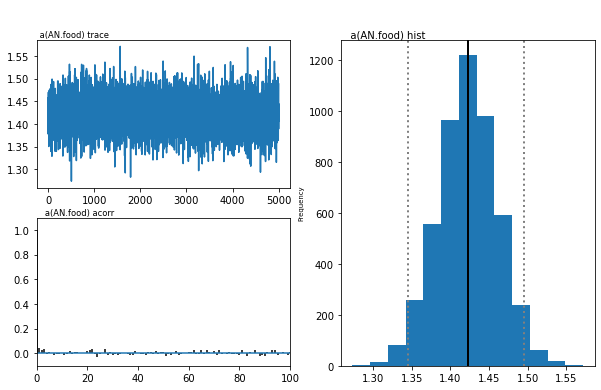

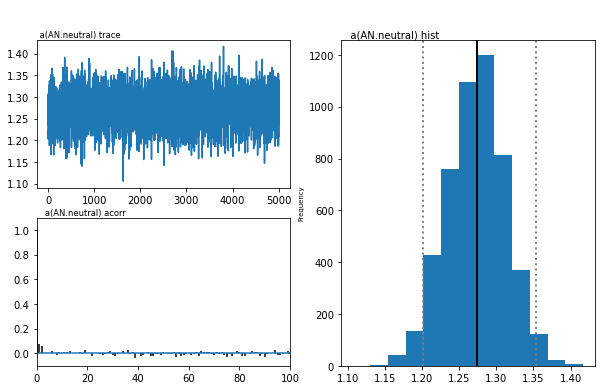

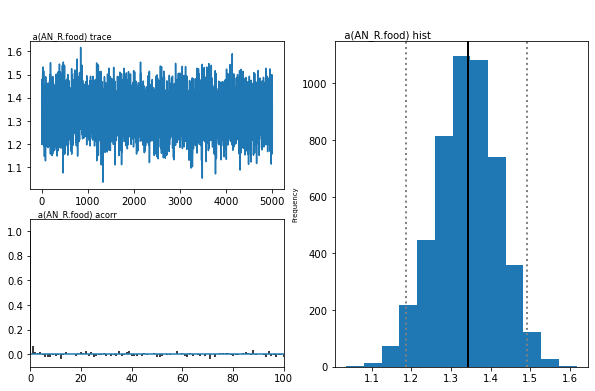

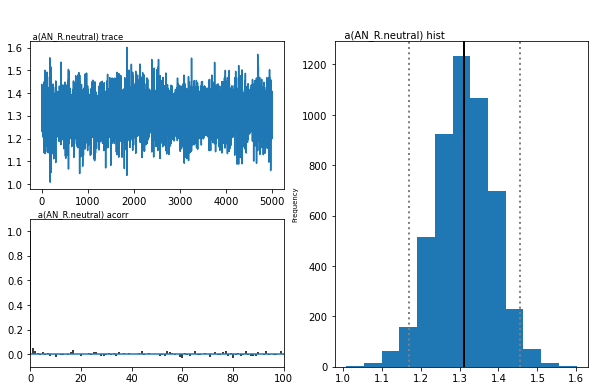

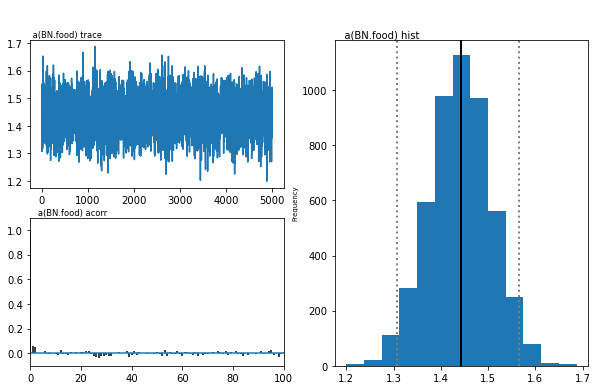

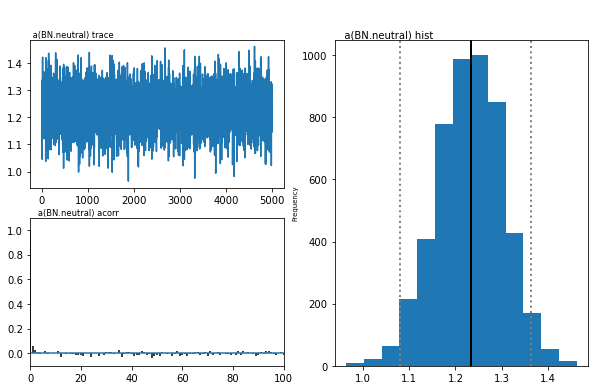

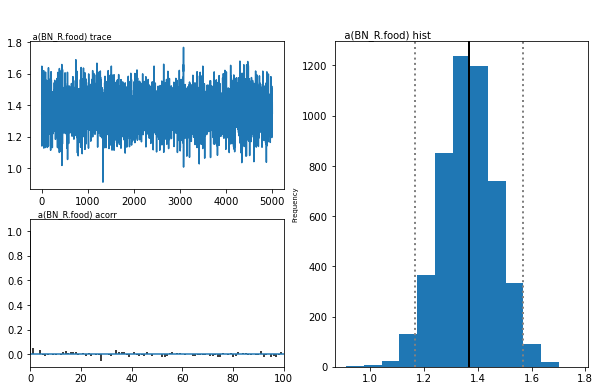

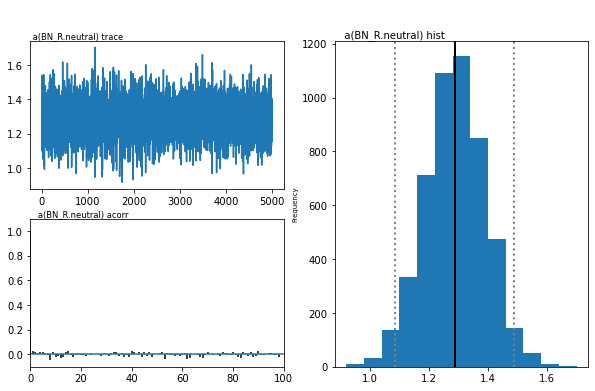

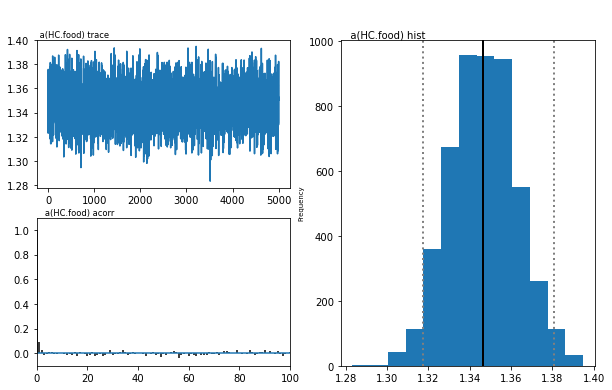

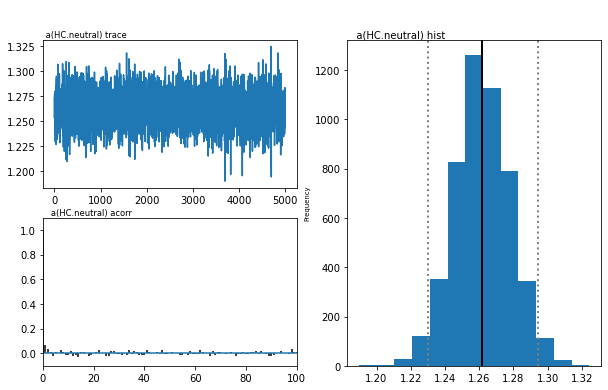

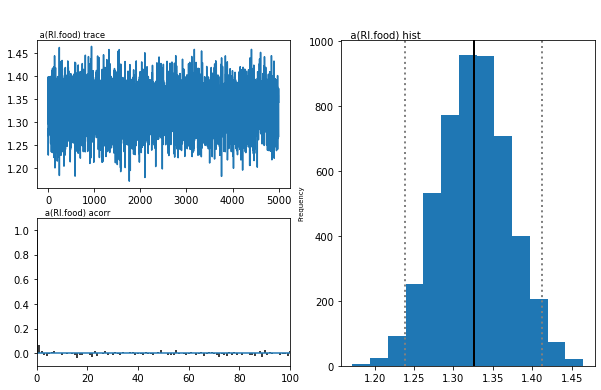

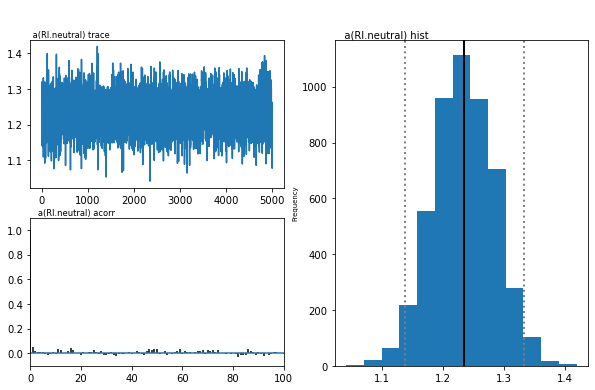

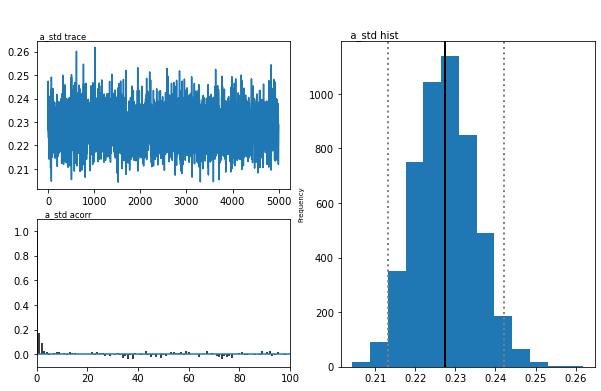

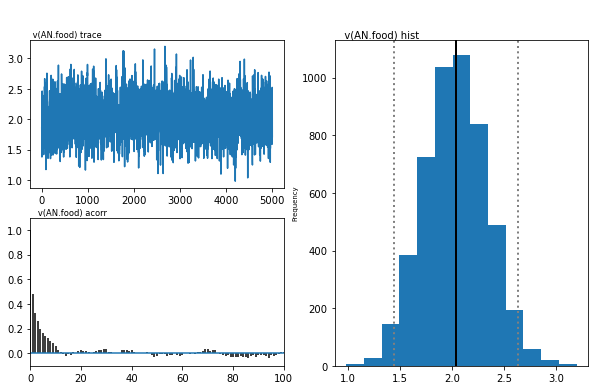

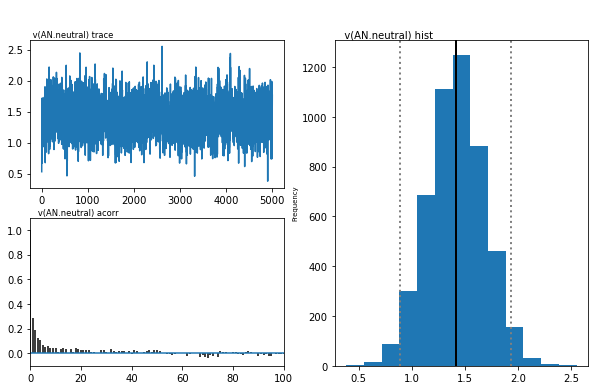

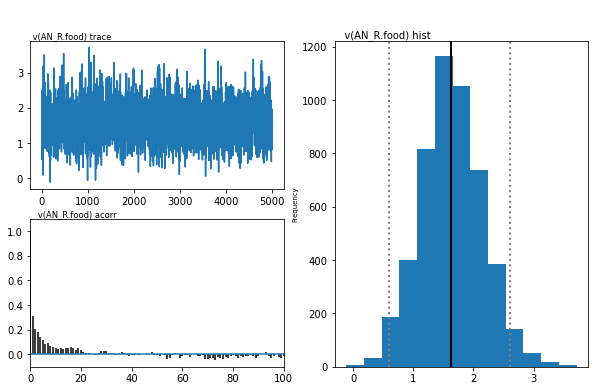

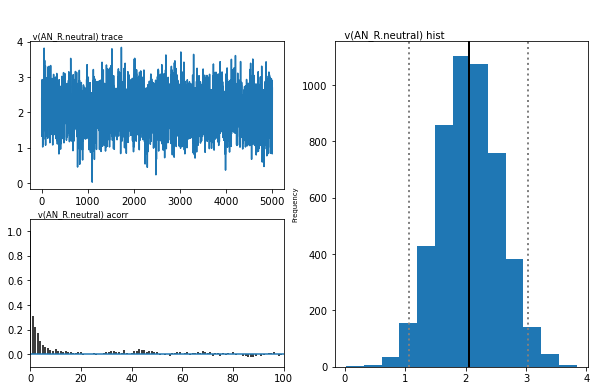

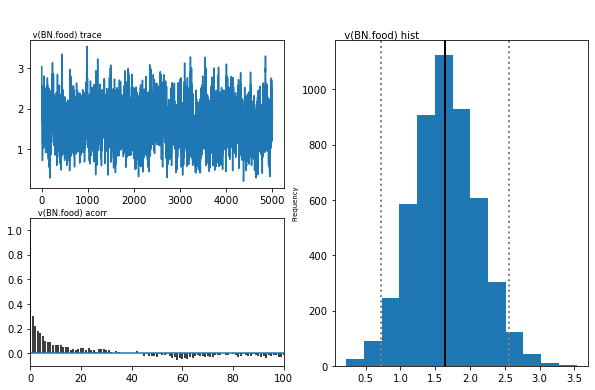

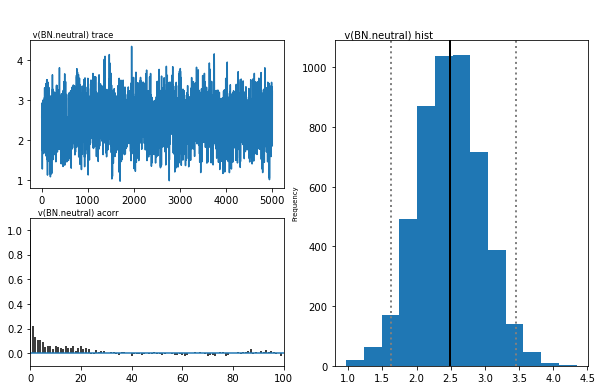

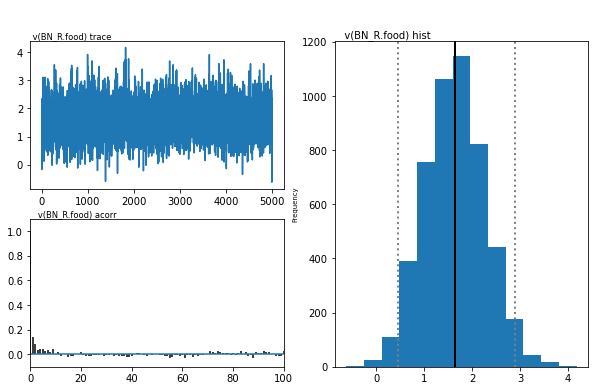

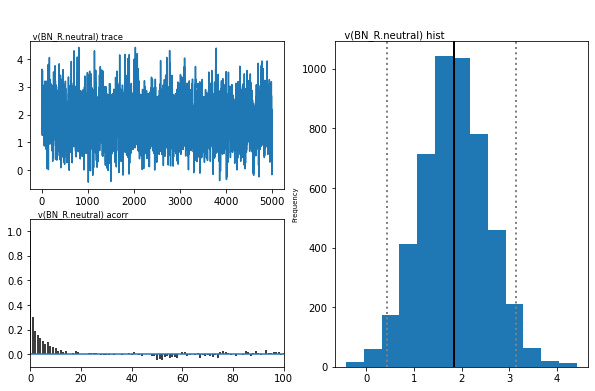

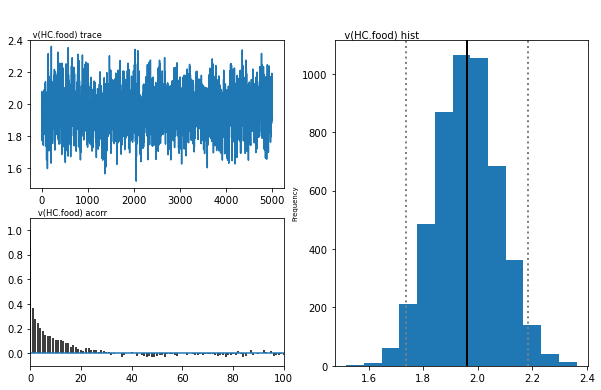

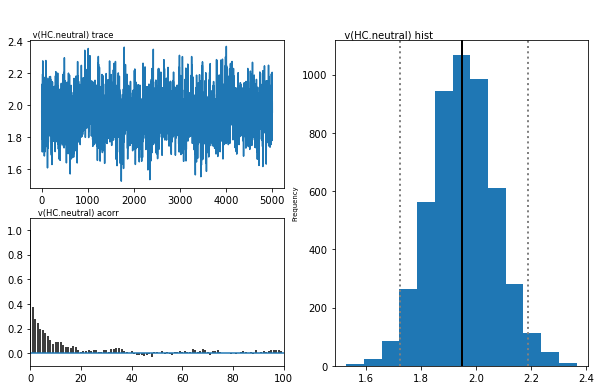

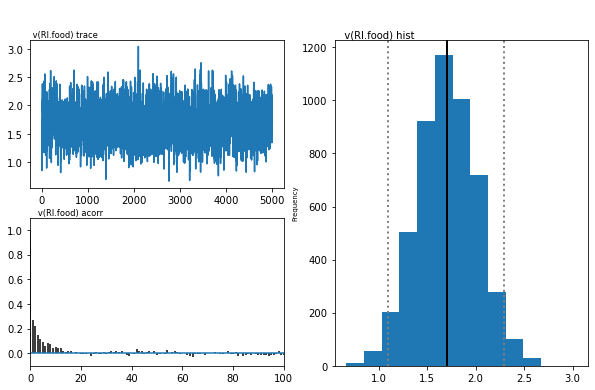

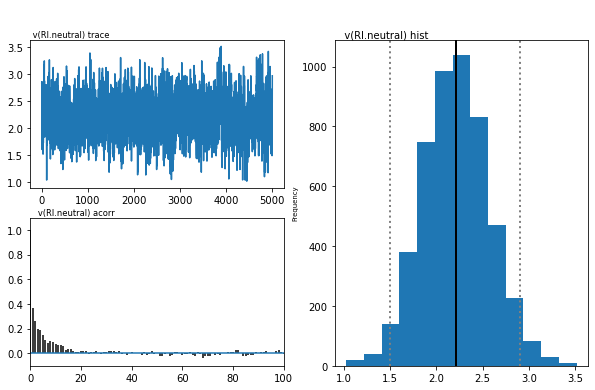

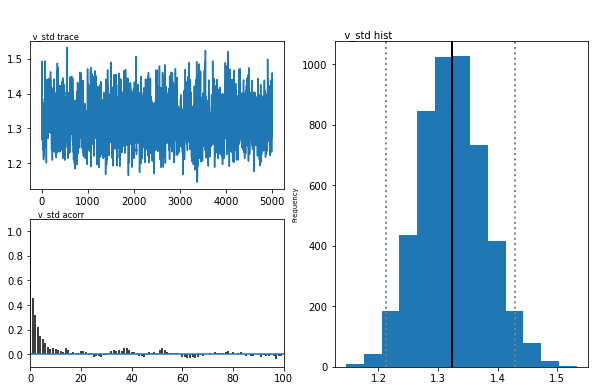

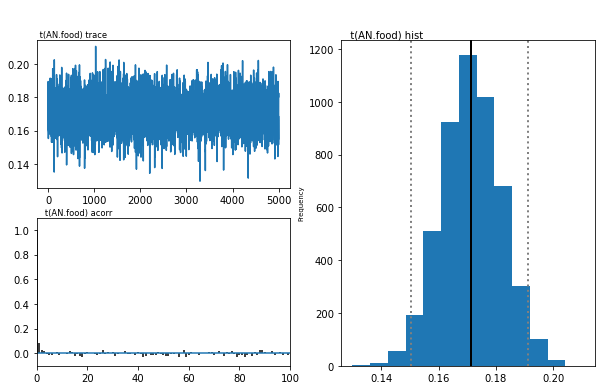

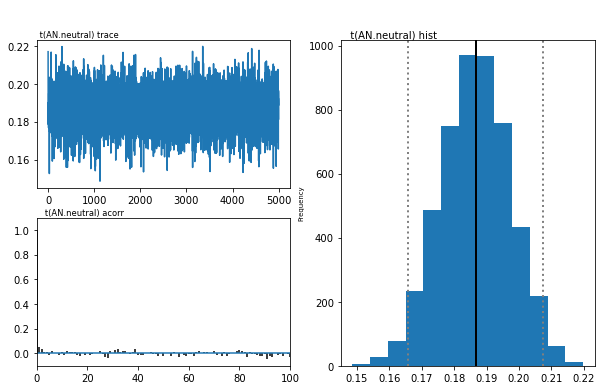

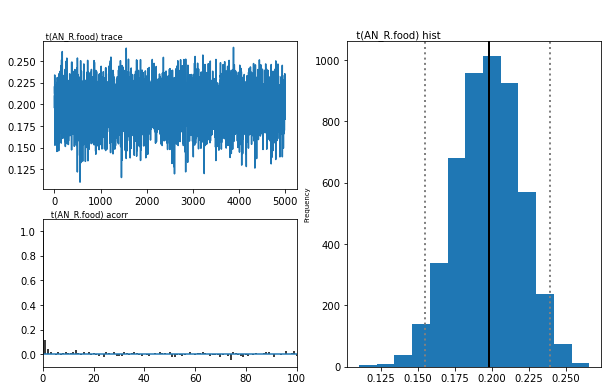

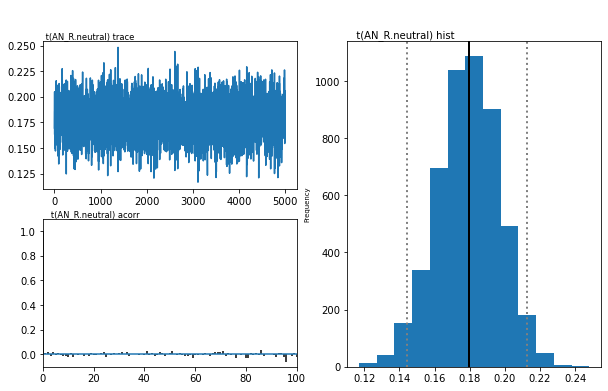

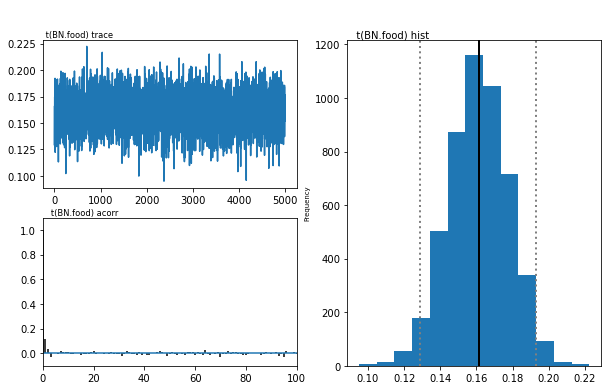

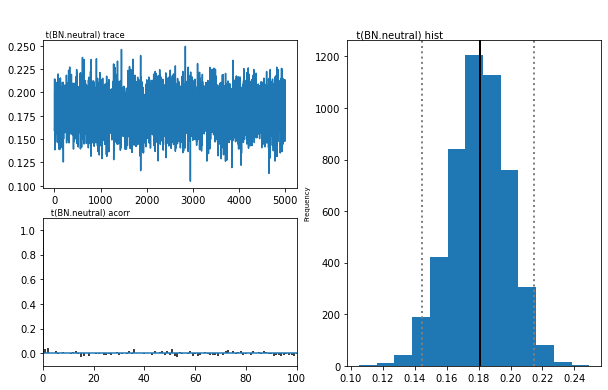

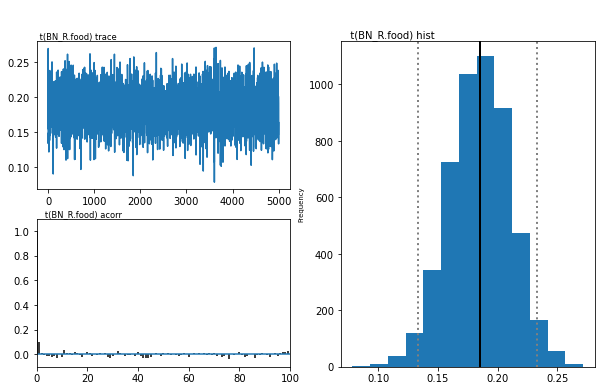

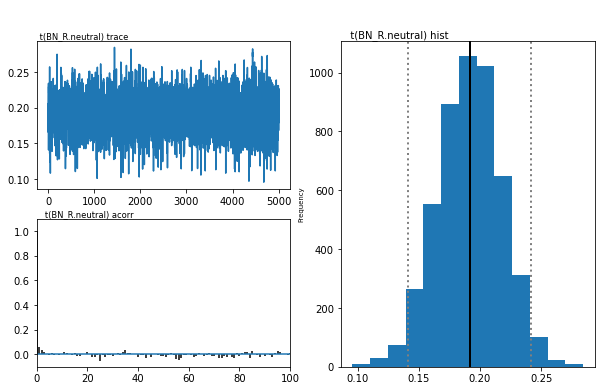

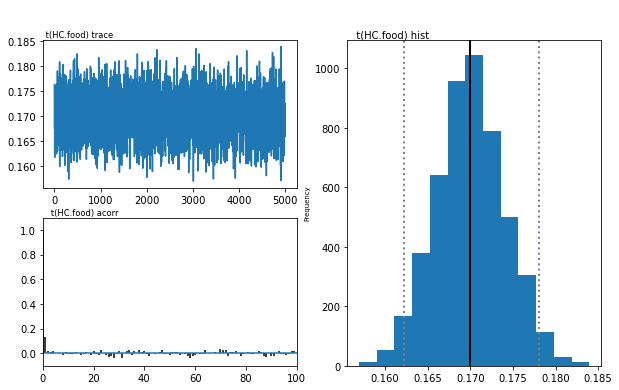

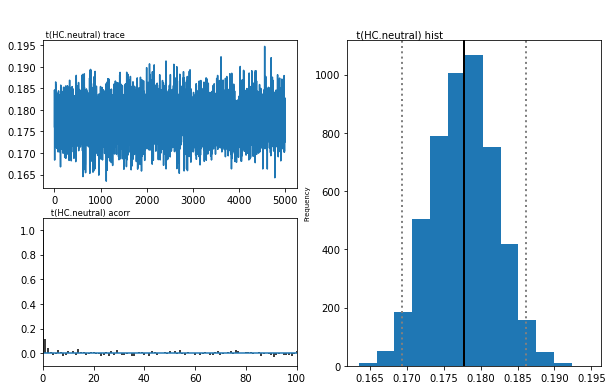

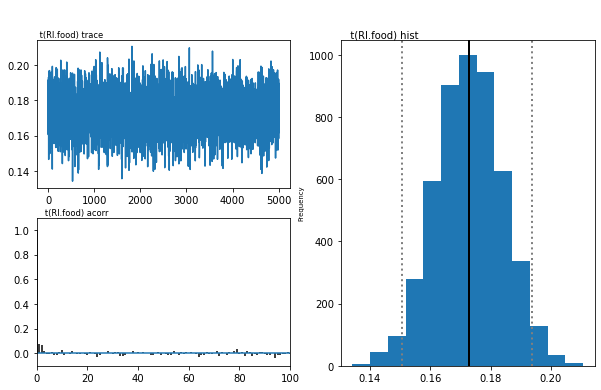

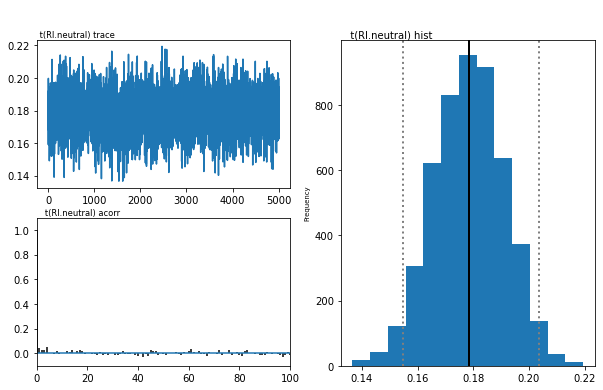

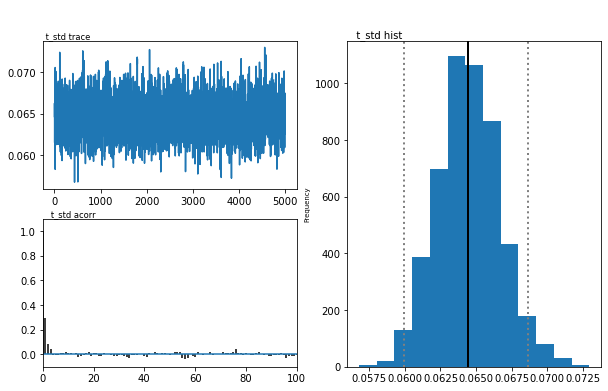

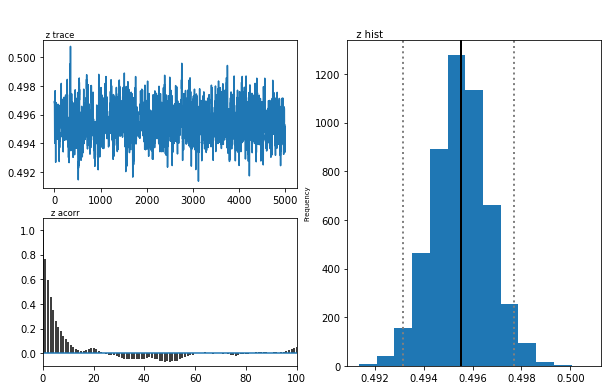

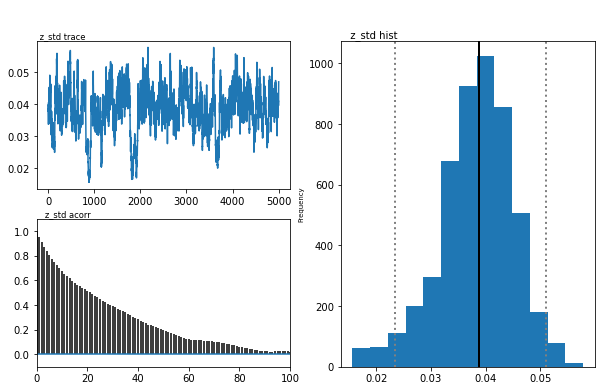

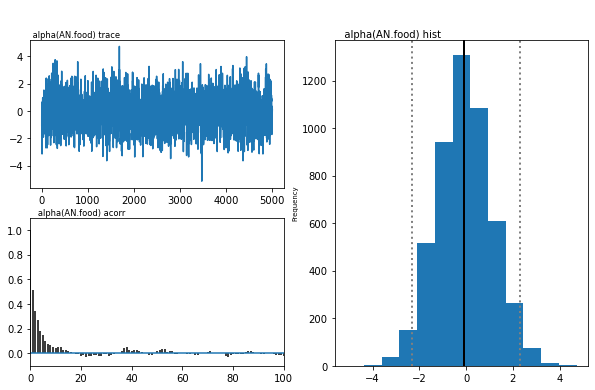

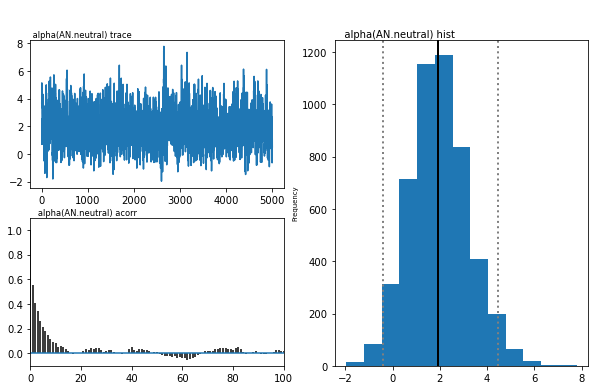

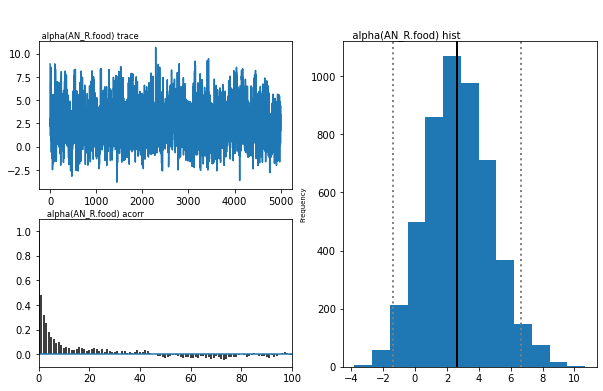

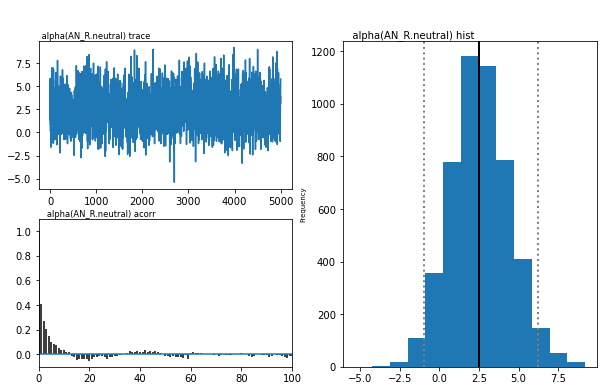

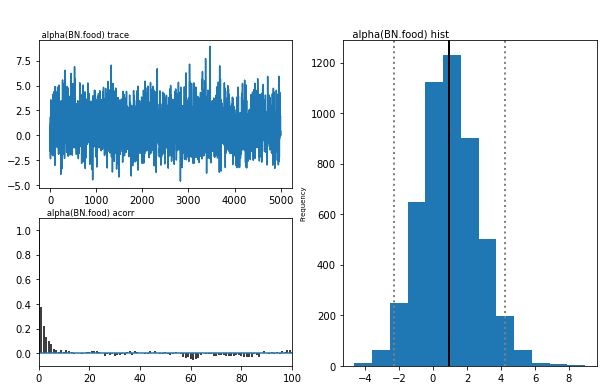

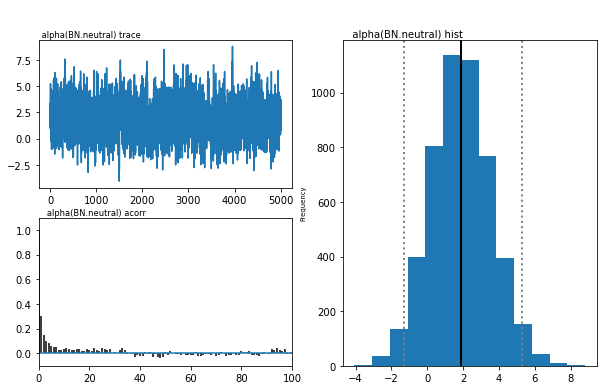

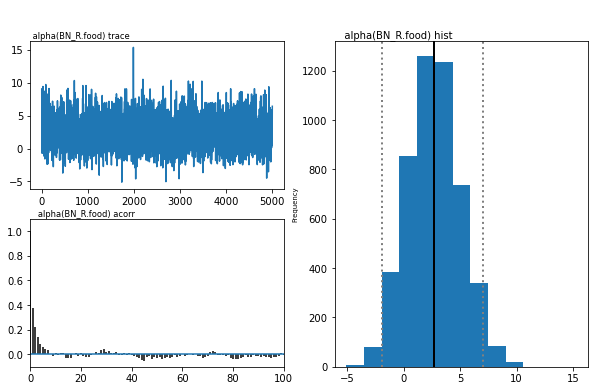

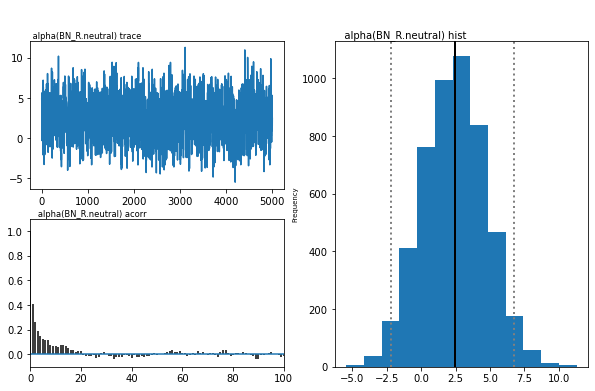

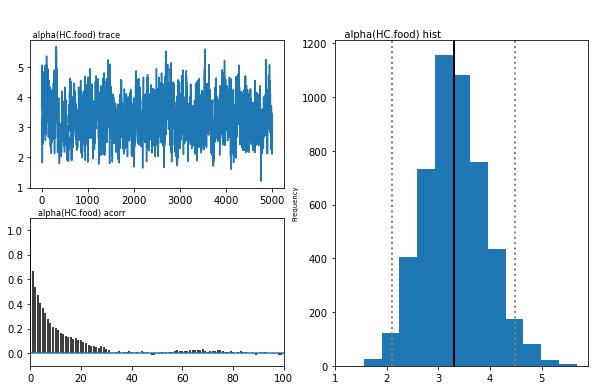

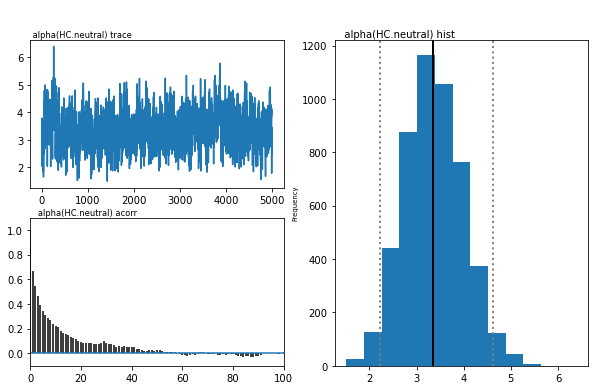

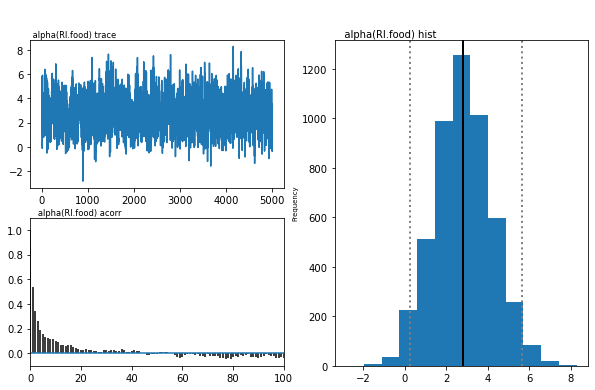

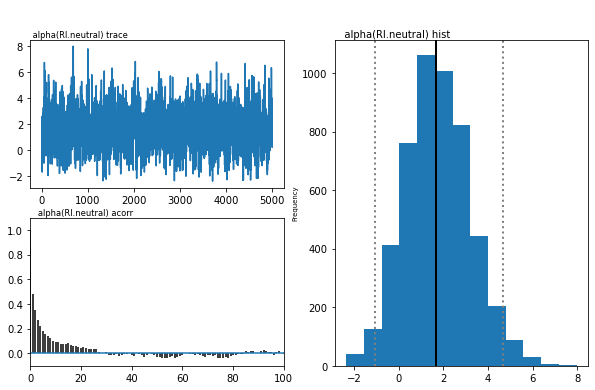

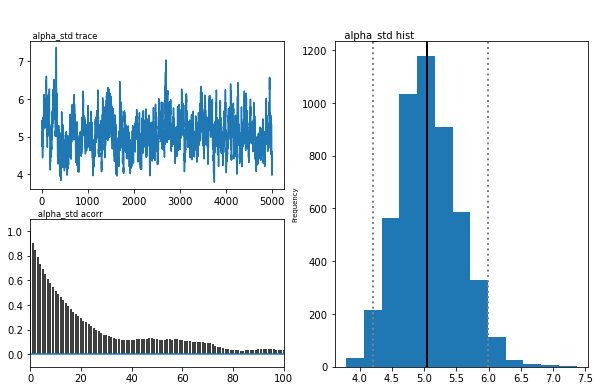

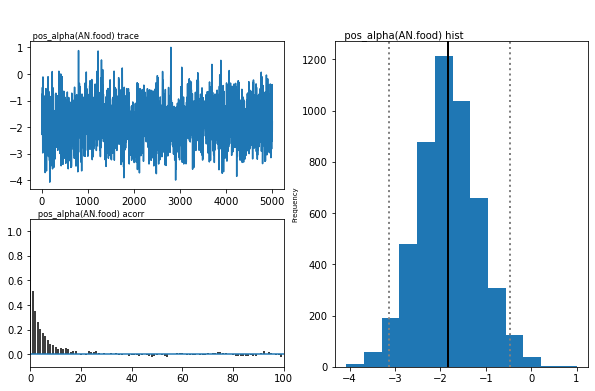

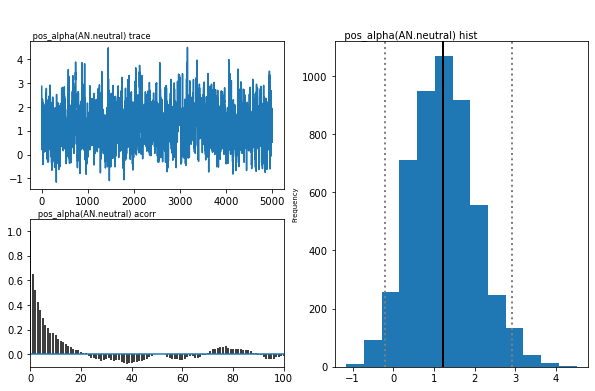

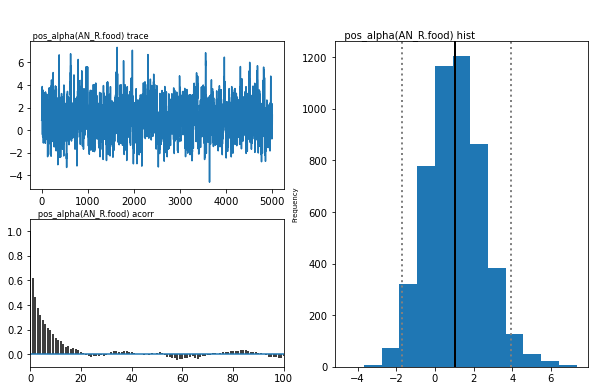

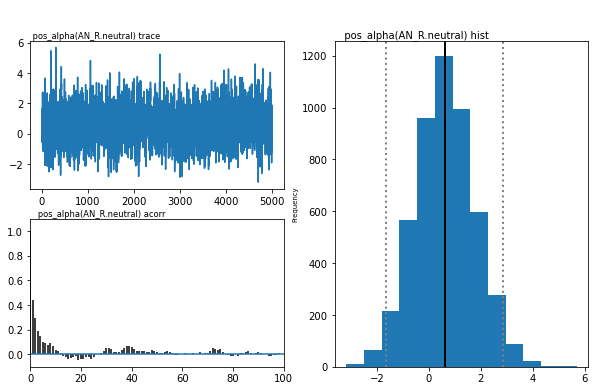

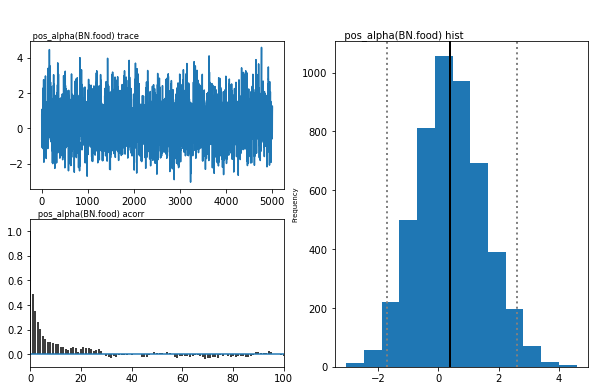

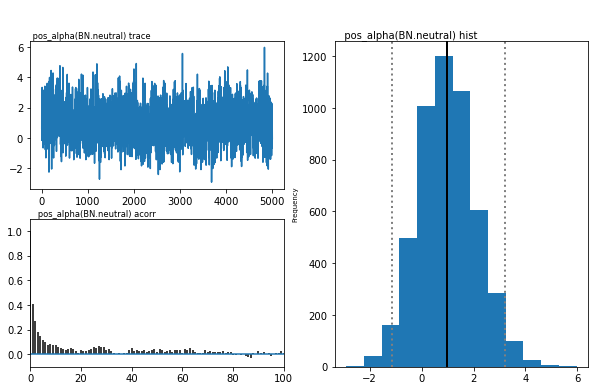

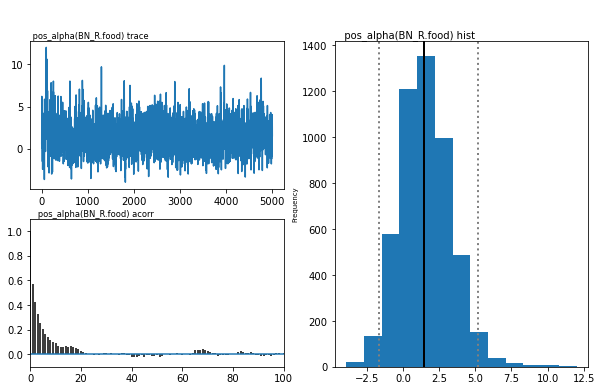

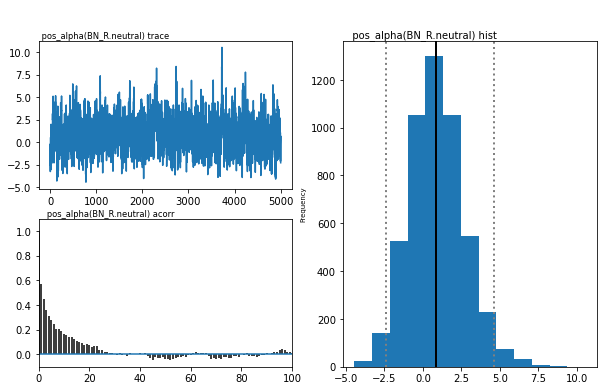

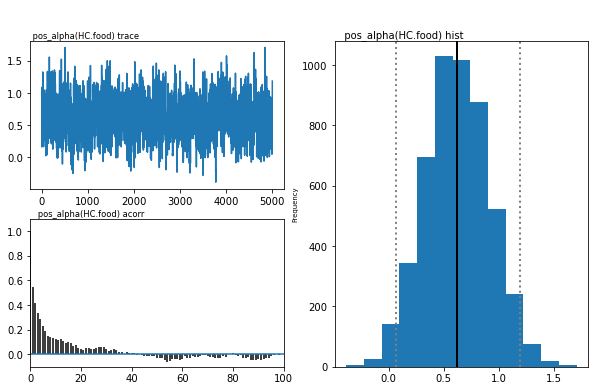

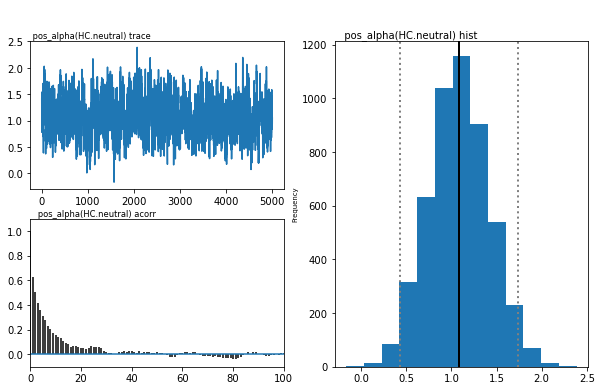

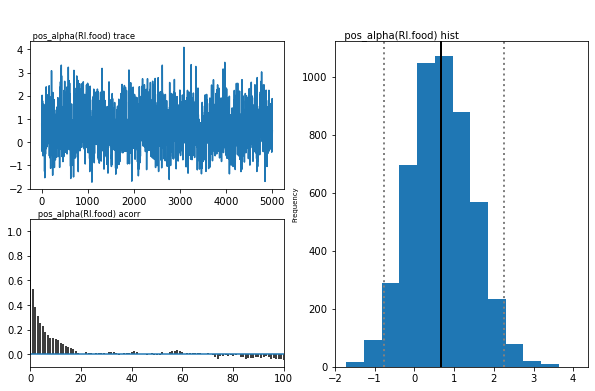

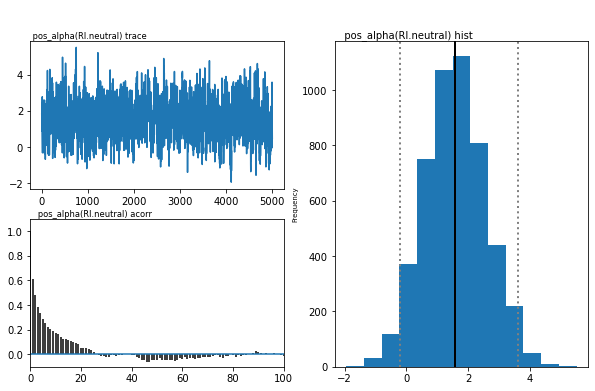

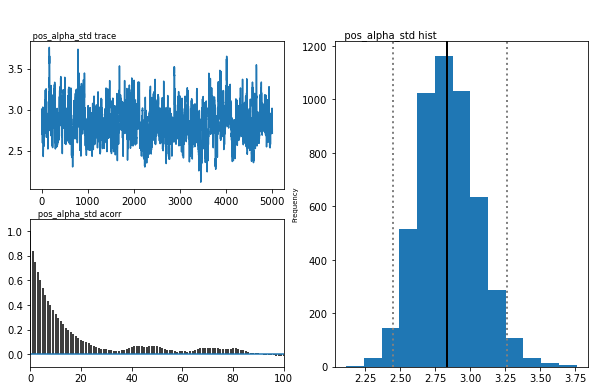

In [51]:
mod1.plot_posteriors()